In [1]:

# =============================================================================
# IMPORT REQUIRED LIBRARIES
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           mean_squared_error, r2_score, roc_curve, auc)
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set plotting style for better visualizations
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


In [ ]:
print("hello")

: 

SUPPORT VECTOR MACHINES (SVM) - CORE CONCEPTS
============================================

What is SVM?
------------
- A supervised learning algorithm used for classification, regression, and outlier detection
- Finds an optimal hyperplane that best separates data points of different classes
- Particularly effective in high-dimensional spaces

Key Components:
1. Hyperplane: A decision boundary that separates data points
2. Support Vectors: Data points closest to the hyperplane that influence its position
3. Margin: The distance between the hyperplane and nearest data points from each class
4. Maximum Margin: SVM aims to maximize this margin for better generalization

Mathematical Foundation:
- Linear SVM finds a hyperplane: w^T * x + b = 0
- Classification: if w^T * x + b > 0 → Class +1, else Class -1
- Objective: Minimize (1/2)||w||^2 subject to y_i(w^T * x_i + b) ≥ 1

In [5]:
# 2. LINEAR SVM - LINEARLY SEPARABLE DATA

np.random.seed(42)

# Generate data for class 1 (blue points)
class1_x = np.random.normal(2, 1, 50)
class1_y = np.random.normal(2, 1, 50)

# Generate data for class 2 (red points)
class2_x = np.random.normal(6, 1, 50)
class2_y = np.random.normal(6, 1, 50)

# Combine data
X_linear = np.vstack([np.column_stack([class1_x, class1_y]), 
                np.column_stack([class2_x, class2_y])])
y_linear = np.hstack([np.ones(50), -np.ones(50)])


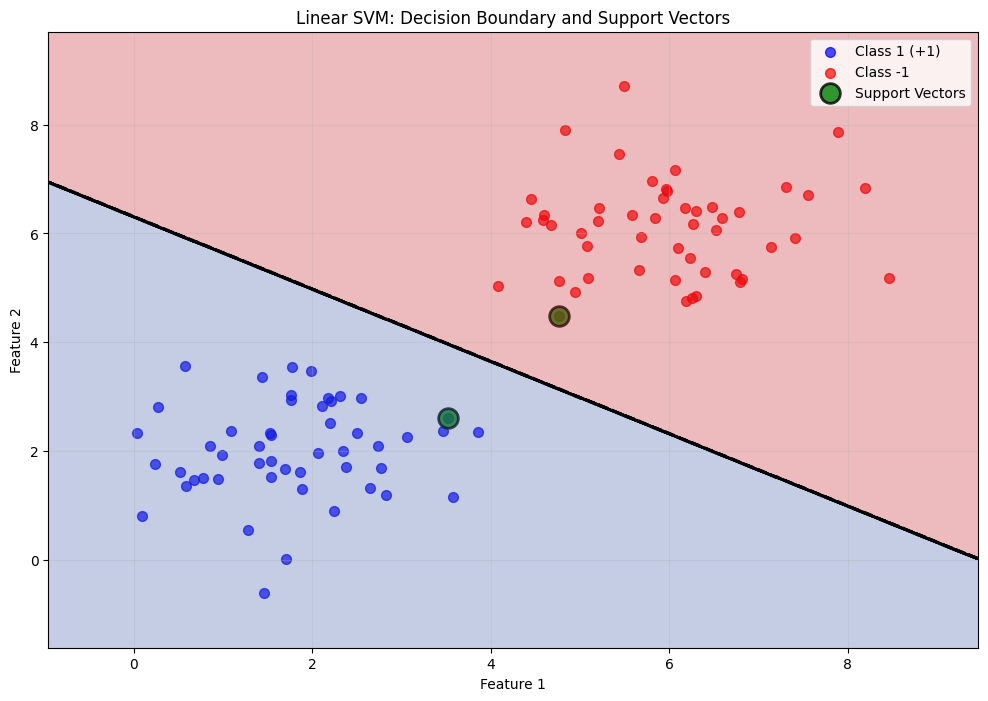

Number of support vectors: 2
Training accuracy: 1.0000
Model parameters - w: [-0.49226999 -0.7401107 ], b: 4.6672


In [6]:


# Train linear SVM
linear_svm = SVC(kernel='linear', C=1.0, random_state=42)
linear_svm.fit(X_linear, y_linear)

# Get support vectors
support_vectors = linear_svm.support_vectors_

# Create visualization
plt.figure(figsize=(12, 8))

# Plot data points
plt.scatter(X_linear[y_linear == 1][:, 0], X_linear[y_linear == 1][:, 1], 
            c='blue', label='Class 1 (+1)', s=50, alpha=0.7)
plt.scatter(X_linear[y_linear == -1][:, 0], X_linear[y_linear == -1][:, 1], 
            c='red', label='Class -1', s=50, alpha=0.7)

# Plot support vectors (highlighted)
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], 
            c='green', s=200, alpha=0.8, linewidth=2, 
            edgecolor='black', label='Support Vectors')

# Plot decision boundary and margin
x_min, x_max = X_linear[:, 0].min() - 1, X_linear[:, 0].max() + 1
y_min, y_max = X_linear[:, 1].min() - 1, X_linear[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                        np.arange(y_min, y_max, 0.01))

Z = linear_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
plt.contour(xx, yy, Z, colors='black', linewidths=2, alpha=0.8)
    
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linear SVM: Decision Boundary and Support Vectors')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print results
print(f"Number of support vectors: {len(support_vectors)}")
print(f"Training accuracy: {linear_svm.score(X_linear, y_linear):.4f}")
print(f"Model parameters - w: {linear_svm.coef_[0]}, b: {linear_svm.intercept_[0]:.4f}")


# NON-LINEAR SVM - KERNEL TRICKS

## KERNEL FUNCTIONS IN SVM
=======================

Why Kernels?
------------
- Linear SVM can only handle linearly separable data
- Real-world data is often non-linearly separable
- Kernel functions transform data into higher-dimensional space where it becomes linearly separable

Common Kernel Functions:
1. Linear: K(x, y) = x^T * y
2. Polynomial: K(x, y) = (γ * x^T * y + r)^d
3. RBF (Gaussian): K(x, y) = exp(-γ * ||x - y||^2)
4. Sigmoid: K(x, y) = tanh(γ * x^T * y + r)

Parameters:
- C: Regularization parameter (controls trade-off between margin and misclassification)
- γ (gamma): Kernel coefficient for RBF, polynomial, and sigmoid kernels
- d: Degree of polynomial kernel
- r: Constant term in polynomial and sigmoid kernels

In [8]:
n_samples = 50
    
# Class 1: top-left and bottom-right quadrants
class1_x1 = np.concatenate([np.random.normal(-2, 0.5, n_samples),
                            np.random.normal(2, 0.5, n_samples)])
class1_x2 = np.concatenate([np.random.normal(2, 0.5, n_samples),
                            np.random.normal(-2, 0.5, n_samples)])

# Class 2: top-right and bottom-left quadrants
class2_x1 = np.concatenate([np.random.normal(2, 0.5, n_samples),
                            np.random.normal(-2, 0.5, n_samples)])
class2_x2 = np.concatenate([np.random.normal(2, 0.5, n_samples),
                            np.random.normal(-2, 0.5, n_samples)])

X_nonlinear = np.vstack([np.column_stack([class1_x1, class1_x2]),
                np.column_stack([class2_x1, class2_x2])])
y_nonlinear = np.hstack([np.ones(2*n_samples), -np.ones(2*n_samples)])

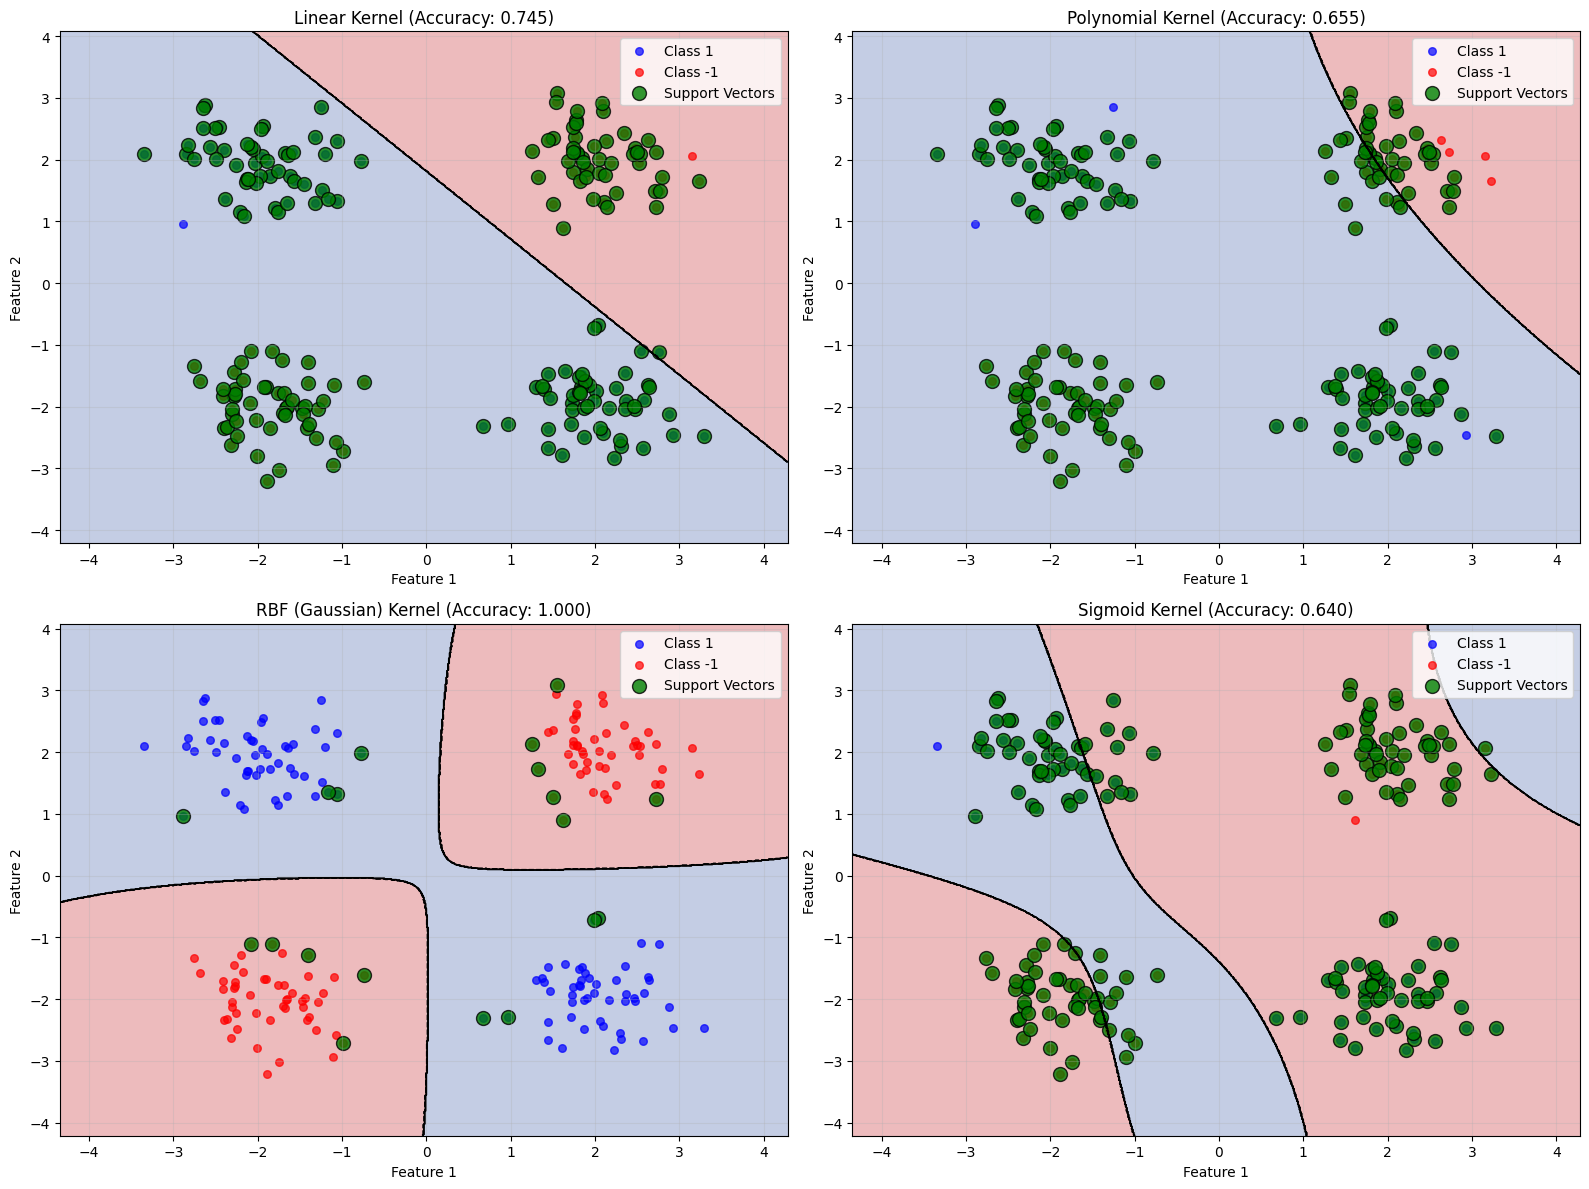


Kernel Performance Comparison:
----------------------------------------
Linear          | Accuracy: 0.745 | Support Vectors: 198
Polynomial      | Accuracy: 0.655 | Support Vectors: 193
RBF (Gaussian)  | Accuracy: 1.000 | Support Vectors: 19
Sigmoid         | Accuracy: 0.640 | Support Vectors: 198


In [9]:

# Define kernels to compare
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
kernel_names = ['Linear', 'Polynomial', 'RBF (Gaussian)', 'Sigmoid']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, (kernel, name) in enumerate(zip(kernels, kernel_names)):
    # Train SVM with current kernel
    if kernel == 'poly':
        svm = SVC(kernel=kernel, C=1.0, gamma='scale', degree=3, random_state=42)
    elif kernel == 'rbf':
        svm = SVC(kernel=kernel, C=1.0, gamma='scale', random_state=42)
    elif kernel == 'sigmoid':
        svm = SVC(kernel=kernel, C=1.0, gamma='scale', random_state=42)
    else:
        svm = SVC(kernel=kernel, C=1.0, random_state=42)
    
    svm.fit(X_nonlinear, y_nonlinear)
    
    # Plot decision boundary
    x_min, x_max = X_nonlinear[:, 0].min() - 1, X_nonlinear[:, 0].max() + 1
    y_min, y_max = X_nonlinear[:, 1].min() - 1, X_nonlinear[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                            np.arange(y_min, y_max, 0.01))
    
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    axes[i].contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    axes[i].contour(xx, yy, Z, colors='black', linewidths=1, alpha=0.8)
    
    # Plot data points
    axes[i].scatter(X_nonlinear[y_nonlinear == 1][:, 0], X_nonlinear[y_nonlinear == 1][:, 1], 
                    c='blue', label='Class 1', s=30, alpha=0.7)
    axes[i].scatter(X_nonlinear[y_nonlinear == -1][:, 0], X_nonlinear[y_nonlinear == -1][:, 1], 
                    c='red', label='Class -1', s=30, alpha=0.7)
    
    # Plot support vectors
    support_vectors = svm.support_vectors_
    axes[i].scatter(support_vectors[:, 0], support_vectors[:, 1], 
                    c='green', s=100, alpha=0.8, linewidth=1, 
                    edgecolor='black', label='Support Vectors')
    
    axes[i].set_title(f'{name} Kernel (Accuracy: {svm.score(X_nonlinear, y_nonlinear):.3f})')
    axes[i].set_xlabel('Feature 1')
    axes[i].set_ylabel('Feature 2')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison results
print("\nKernel Performance Comparison:")
print("-" * 40)
for kernel, name in zip(kernels, kernel_names):
    if kernel == 'poly':
        svm = SVC(kernel=kernel, C=1.0, gamma='scale', degree=3, random_state=42)
    elif kernel == 'rbf':
        svm = SVC(kernel=kernel, C=1.0, gamma='scale', random_state=42)
    elif kernel == 'sigmoid':
        svm = SVC(kernel=kernel, C=1.0, gamma='scale', random_state=42)
    else:
        svm = SVC(kernel=kernel, C=1.0, random_state=42)
    
    svm.fit(X_nonlinear, y_nonlinear)
    accuracy = svm.score(X_nonlinear, y_nonlinear)
    n_support = len(svm.support_vectors_)
    print(f"{name:15} | Accuracy: {accuracy:.3f} | Support Vectors: {n_support}")

